# Loading human plays' data

In [1]:
import json
import pandas as pd
import numpy as np
import mmap

In [2]:
# games_jsons = []
# ix = 0
# with open("../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl", "r") as json_file:
#     for line in json_file:
#         games_jsons.append(json.loads(line))

In [3]:
# Load the json data
completed = False
games_jsons = []
with open("../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl", "r+b") as json_file:
    with mmap.mmap(json_file.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_object:
        for i, line in enumerate(iter(mmap_object.readline, b"")):
            tmp = json.loads(line.decode("utf-8"))
            if tmp["map"] == "standard":
                if completed:
                    for phase in tmp["phases"]:
                        if phase["name"] == "COMPLETED":
                            games_jsons.append(tmp)
                else:
                    games_jsons.append(tmp)
            if len(games_jsons) == 30:
                print("last game id is", i)
                break

last game id is 47


## Uncomment to load RL single game data

In [4]:

# games_jsons = []
# json_file_path = "../data/game_rl_0.json"

# with open(json_file_path, 'r') as j:
#       games_jsons.append(json.loads(j.read()))

In [5]:
# Convert to a pandas dataframe
df = pd.DataFrame(games_jsons)

In [6]:
# df = df.loc[df["map"] == "standard"].reset_index(drop=True)

In [7]:
df


,id,map,rules,phases
0,uXFQ2zgI-DUrgwlS,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
1,X9hvE_k6LbQrauYc,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
2,lVp6PZxk3Jpufc9Z,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
3,rW_Q9TpidGLGD2EL,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
4,HYc16KDWi8zHNlmn,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
5,_xZyPB0yRDQjRB4x,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
6,CRbbNicSK5Jc-qmb,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
7,ZSFmLzi-Th6lbpxy,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
8,57xpw6Z-8IKo2hDK,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."
9,sdKZrT-i_BvEZsFU,standard,"[NO_PRESS, POWER_CHOICE]","[{'name': 'S1901M', 'state': {'timestamp': 154..."


In [8]:
games = df['phases']

In [9]:
games.apply(lambda x: x[0])

0     {'name': 'S1901M', 'state': {'timestamp': 1542...
1     {'name': 'S1901M', 'state': {'timestamp': 1542...
2     {'name': 'S1901M', 'state': {'timestamp': 1542...
3     {'name': 'S1901M', 'state': {'timestamp': 1542...
4     {'name': 'S1901M', 'state': {'timestamp': 1542...
5     {'name': 'S1901M', 'state': {'timestamp': 1542...
6     {'name': 'S1901M', 'state': {'timestamp': 1542...
7     {'name': 'S1901M', 'state': {'timestamp': 1542...
8     {'name': 'S1901M', 'state': {'timestamp': 1542...
9     {'name': 'S1901M', 'state': {'timestamp': 1542...
10    {'name': 'S1901M', 'state': {'timestamp': 1542...
11    {'name': 'S1901M', 'state': {'timestamp': 1542...
12    {'name': 'S1901M', 'state': {'timestamp': 1542...
13    {'name': 'S1901M', 'state': {'timestamp': 1542...
14    {'name': 'S1901M', 'state': {'timestamp': 1542...
15    {'name': 'S1901M', 'state': {'timestamp': 1542...
16    {'name': 'S1901M', 'state': {'timestamp': 1542...
17    {'name': 'S1901M', 'state': {'timestamp': 

In [10]:
type(games)

pandas.core.series.Series

In [11]:
for game in games:
    for ix, iy in enumerate(game):
        game[ix]['phase_id'] = ix

In [12]:
def flatten_json(input):
    out = {}
    out['game_id'] = input['state']['game_id']
    out['phase_id'] = input['phase_id']
    out['phase_name'] = input['name']
    results_units_keys = [x for x in input['results']]

    assert input['orders'].items() 
    for player, orders in input['orders'].items():
        if orders is not None:
            if orders:
                for order in orders:
                    out['coordinator'] = player
                    out['type'] = order.split()[0]
                    out['current_location'] = order.split()[1]
                    out['action'] = order.split()[2]
                    unit = order.split()[0]+ ' ' + order.split()[1]
                    # print("unit result is: ", unit , unit in results_units, results_units)
                    if input['results']:
                        out['results'] = input['results'][unit]
                    else:
                        print("empty results")
                        print(order)
                    if unit in results_units_keys:
                        results_units_keys.remove(unit)
                    out['impact_location'] = []
                    if out['action'] == '-' or out['action'] == 'R':
                        assert len(order.split()) == 4 or len(order.split()) == 5, order
                        out['impact_location'] = order.split()[3]
                    yield(out)
                
            else:
                # uncmomment these if you need a row for empty orders (in group by you will get 1 instead of 0)
                # out['coordinator'] = player
                # out['type'] = -1
                # out['current_location'] = -1
                # out['action'] = -1
                # out['results'] = -1
                # out['impact_location'] = -1
                # if out['action'] == '-' or out['action'] == 'R':
                #     assert len(order.split()) == 4 or len(order.split()) == 5, order
                #     out['impact_location'] = order.split()[3]
                # yield(out)
                pass

    if len(results_units_keys)>0:
        # uncomment for completed games
        all_orders = [order for order in input['orders'].values()]
        total_len = 0
        for l in all_orders:
            total_len += len(l)
        if total_len == 0:
            print(out)
        assert [order for order in input['orders'].values()]
        for unit in results_units_keys:
            if unit == 'WAIVE': ## FIXME: double check this later
                continue
            assert len(unit.split()) == 2, unit
            out['coordinator'] = 'RA'
            for player in input["state"]["units"]:
                if unit in input["state"]["units"][player]:
                    out['coordinator'] = player

            if len(unit.split()[0]) != 1: # if we have sth like HOL D: "void"
                assert input['results'][unit][0] == 'void', input['results'][unit]
                location = unit.split()[0]
                assert unit.split()[1] == 'D', unit.split()[1]
                # find the corresponding key in the results
                for key in input['results']:
                    if key.split()[1] == location:
                        assert input['results'][key][0] == "disband", input['results'][key]
                        input['results'][key].append(input['results'][unit][0])
                        break
            else:
                out['type'] = unit.split()[0]
                out['current_location'] = unit.split()[1]
                out['results'] = input['results'][unit]
                out['action'] = -2
                out['impact_location'] = -2
                yield(out)

In [13]:
all_records = []
for idx, game in enumerate(games):
  for idx, phase in enumerate(game):
    row_generator = flatten_json(phase)
    assert row_generator is not None, row_generator
    for row in row_generator:
      all_records.append(row.copy())

empty results
A VEN D
{'game_id': 'lVp6PZxk3Jpufc9Z', 'phase_id': 37, 'phase_name': 'S1909M'}
{'game_id': 'rW_Q9TpidGLGD2EL', 'phase_id': 33, 'phase_name': 'F1908R'}
{'game_id': '_xZyPB0yRDQjRB4x', 'phase_id': 31, 'phase_name': 'S1908M'}
{'game_id': '_xZyPB0yRDQjRB4x', 'phase_id': 32, 'phase_name': 'F1908M'}
{'game_id': 'CRbbNicSK5Jc-qmb', 'phase_id': 58, 'phase_name': 'S1915M'}
{'game_id': '57xpw6Z-8IKo2hDK', 'phase_id': 41, 'phase_name': 'F1910R'}
{'game_id': 'sdKZrT-i_BvEZsFU', 'phase_id': 35, 'phase_name': 'F1908R'}
{'game_id': 'p6m8jMuDPsM0dtUh', 'phase_id': 23, 'phase_name': 'W1906A'}
{'game_id': 'p6m8jMuDPsM0dtUh', 'phase_id': 41, 'phase_name': 'F1910R'}
{'game_id': 'oIIaa9M0NHem5XE_', 'phase_id': 62, 'phase_name': 'S1916M'}
{'game_id': '5F6upbHF5NZlWuY_', 'phase_id': 35, 'phase_name': 'S1909M'}
{'game_id': 'LVR_gAlKmfjGb8V2', 'phase_id': 13, 'phase_name': 'S1904M'}
{'game_id': 'h9QEPT6s5-Fi1WrV', 'phase_id': 47, 'phase_name': 'F1912M'}
empty results
F SPA/SC D
empty results
A G

In [14]:
complete_df = pd.DataFrame.from_records(all_records)

In [15]:
complete_df.loc[complete_df['coordinator'] == 'RA']

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location
203,X9hvE_k6LbQrauYc,6,W1902A,RA,F,SEV,-2,[disband],-2
344,X9hvE_k6LbQrauYc,13,F1904R,RA,A,HOL,-2,"[disband, void]",-2
1719,rW_Q9TpidGLGD2EL,14,F1904R,RA,F,TRI,-2,"[disband, void]",-2
1918,rW_Q9TpidGLGD2EL,26,S1907R,RA,F,RUM,-2,"[disband, void]",-2
2292,HYc16KDWi8zHNlmn,16,F1904R,RA,A,SPA,-2,"[disband, void]",-2
...,...,...,...,...,...,...,...,...,...
20026,qispC8HwumqyWTWM,29,F1907R,RA,A,BUL,-2,"[disband, void]",-2
20101,qispC8HwumqyWTWM,34,W1908A,RA,A,HOL,-2,[disband],-2
20243,qispC8HwumqyWTWM,43,W1910A,RA,A,BER,-2,[disband],-2
20444,qispC8HwumqyWTWM,52,F1913R,RA,F,BER,-2,"[disband, void]",-2


In [16]:
complete_df['unique_unit_id'] = -1

## Temporal Binding

In [17]:
def assign_unit_id(phase_df, source_unit_id_map, dest_unit_id_map, _id):

    # fror each row in the phase df
    for idx, row in phase_df.iterrows():

        # if current location or type of army in invalid skip the row (we only deal with valid orders)
        if row['action'] == -1 or row['type'] == 'N':
            continue
        
        # get the current location of the unit
        source_unit = row['type'] + ' ' + row['current_location']

        # if the location is not in the map, add it to the map (in other phases the same unit can be used, hence checking the condition _ dictionaries are global, have data across phases)
        if source_unit not in source_unit_id_map:
            source_unit_id_map[source_unit] = _id
            _id += 1

        # destination dict is synced with source dict after the loop, so that we can use updated info at the beginning of each assignment
        # row['unique_unit_id'] = source_unit_id_map[source_unit]
        phase_df.loc[idx,'unique_unit_id'] = source_unit_id_map[source_unit]

        if row['action'] == '-':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    try:
                        dest_unit = row['type'] + ' ' + dest_location
                    except:
                        print("dest location error", row)
                        return
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                        # source_unit_id_map[source_unit]
                        # print(source_unit_id_map.pop(source_unit))
                elif 'disband' in result:
                    source_unit_id_map.pop(source_unit)
                    
        elif row['action'] == 'R':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    dest_unit = row['type'] + ' ' + dest_location
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    if len(result) > 1:
                        if 'void' in result:
                                print(result)
                    source_unit_id_map.pop(source_unit)

        elif row['action'] == 'D':
            result = row['results']
            assert source_unit in source_unit_id_map
            if isinstance(result, list):
                if len(result) == 0:
                    source_unit_id_map.pop(source_unit)
                elif 'void' in result:
                    print("void disband", row)
        
        elif row['action'] == 'B':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'H':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'S':
            assert source_unit in source_unit_id_map
        
        elif row['action'] == 'C':
            assert source_unit in source_unit_id_map

        # for added result rows
        elif row['action'] == -2:
            result = row['results']
            assert source_unit in source_unit_id_map
            if isinstance(result, list):
                if len(result) == 0:
                    source_unit_id_map.pop(source_unit)
                elif 'disband' in result and 'void' not in result:
                    source_unit_id_map.pop(source_unit)
                    # print("disband")
                elif 'disband' in result and 'void' in result:
                    # print("void disband")
                    pass
        else:
            print("invalid action", row)

    # merge the source and destination dictionaries into one
    source_unit_id_map.update(dest_unit_id_map)
    # remove the destination dict (values get updated based on old data if we don't do this)
    dest_unit_id_map = {}

    return source_unit_id_map, dest_unit_id_map, _id

In [18]:
unique_games = complete_df["game_id"].unique()

In [19]:
game_phase_df_list = []
for idx, game_id in enumerate(unique_games):
    print(idx, game_id)
    s_dict = {}
    d_dict = {}
    _id = 1
    game_df = complete_df.loc[complete_df["game_id"].apply(lambda x: x == game_id)]
    unique_phases = game_df['phase_id'].unique()
    for phase in unique_phases:
        condition = game_df["phase_id"].apply(lambda x: x == phase)
        phase_df = game_df.loc[condition]
        s_dict, d_dict, _id = assign_unit_id(phase_df, s_dict, d_dict, _id)
        game_phase_df_list.append(phase_df)

0 uXFQ2zgI-DUrgwlS
1 X9hvE_k6LbQrauYc
2 lVp6PZxk3Jpufc9Z
3 rW_Q9TpidGLGD2EL


/Users/ens/miniforge3/envs/marl/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


4 HYc16KDWi8zHNlmn
5 _xZyPB0yRDQjRB4x
6 CRbbNicSK5Jc-qmb
7 ZSFmLzi-Th6lbpxy
8 57xpw6Z-8IKo2hDK
9 sdKZrT-i_BvEZsFU
10 p6m8jMuDPsM0dtUh
11 oIIaa9M0NHem5XE_
12 5F6upbHF5NZlWuY_
13 7uKSGh-EG86tfpyh
14 0yv59hl6e5Ensb4M
15 NxMelzPAbZMYgrHY
16 omNMEctxL53gLSC0
17 LVR_gAlKmfjGb8V2
18 h9QEPT6s5-Fi1WrV
19 cSaeUT4h0rewXGWH
20 5JrcwYeklprQyQ9E
21 D619QzLd0FKfXi4m
22 kLq1Qi6MqjKKDd4G
23 HaJIleHsrwGvcRwO
24 BKJDUpmRsGnikiLG
25 8Vv4RupS6oaY3W9-
26 UUaNd1k82YhdM3Rh
27 EWfQsnYLG5-OZLGU
28 qispC8HwumqyWTWM
29 1IbGdARWCes1lsqm


In [20]:
# cdf = pd.concat(game_phase_df_list, ignore_index=True)
cdf = pd.concat(game_phase_df_list)

## Check the concatenated df

In [21]:
cdf

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
0,uXFQ2zgI-DUrgwlS,0,S1901M,AUSTRIA,F,TRI,H,[],[],1
1,uXFQ2zgI-DUrgwlS,0,S1901M,AUSTRIA,A,VIE,H,[],[],2
2,uXFQ2zgI-DUrgwlS,0,S1901M,AUSTRIA,A,BUD,-,[],SER,3
3,uXFQ2zgI-DUrgwlS,0,S1901M,ENGLAND,A,LVP,-,[],EDI,4
4,uXFQ2zgI-DUrgwlS,0,S1901M,ENGLAND,F,EDI,-,[],NWG,5
...,...,...,...,...,...,...,...,...,...,...
21212,1IbGdARWCes1lsqm,35,F1909M,RUSSIA,A,MUN,S,[],[],35
21213,1IbGdARWCes1lsqm,35,F1909M,RUSSIA,F,BLA,S,[],[],48
21214,1IbGdARWCes1lsqm,35,F1909M,RUSSIA,A,BUD,S,[],[],19
21215,1IbGdARWCes1lsqm,35,F1909M,RUSSIA,A,BOH,S,[],[],23


In [22]:
complete_df.loc[complete_df["game_id"] == 'uXFQ2zgI-DUrgwlS']['phase_id'].unique()

array([0, 1, 2, 3, 4])

In [23]:
cdf.loc[cdf['coordinator'] == 'RA'][:40].sort_values(by=['phase_id', 'unique_unit_id'])

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
4014,ZSFmLzi-Th6lbpxy,2,W1901A,RA,F,SEV,-2,[disband],-2,19
4713,57xpw6Z-8IKo2hDK,2,W1901A,RA,F,RUM,-2,[disband],-2,19
7809,5F6upbHF5NZlWuY_,2,W1901A,RA,F,SEV,-2,[disband],-2,19
8483,7uKSGh-EG86tfpyh,5,W1902A,RA,A,GRE,-2,[disband],-2,2
2485,_xZyPB0yRDQjRB4x,6,W1902A,RA,F,SEV,-2,[disband],-2,16
9019,0yv59hl6e5Ensb4M,6,F1902R,RA,F,RUM,-2,"[disband, void]",-2,16
203,X9hvE_k6LbQrauYc,6,W1902A,RA,F,SEV,-2,[disband],-2,19
6777,oIIaa9M0NHem5XE_,7,F1902R,RA,F,BUL/SC,-2,"[disband, void]",-2,2
10900,omNMEctxL53gLSC0,8,W1903A,RA,F,MAR,-2,[disband],-2,34
6151,p6m8jMuDPsM0dtUh,10,W1903A,RA,F,POR,-2,[disband],-2,6


In [24]:
cdf.loc[cdf['game_id'] == 'lVp6PZxk3Jpufc9Z']

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
855,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,A,VIE,H,[],[],1
856,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,F,TRI,H,[],[],2
857,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,A,BUD,H,[],[],3
858,lVp6PZxk3Jpufc9Z,0,S1901M,ENGLAND,F,EDI,-,[],NTH,4
859,lVp6PZxk3Jpufc9Z,0,S1901M,ENGLAND,A,LVP,-,[],YOR,5
...,...,...,...,...,...,...,...,...,...,...
1443,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,A,WAR,-2,[],-2,48
1444,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,F,LYO,-2,[],-2,47
1445,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,F,TUN,-2,[],-2,15
1446,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,A,ROM,-2,[],-2,64


In [25]:
unique_games

array(['uXFQ2zgI-DUrgwlS', 'X9hvE_k6LbQrauYc', 'lVp6PZxk3Jpufc9Z',
       'rW_Q9TpidGLGD2EL', 'HYc16KDWi8zHNlmn', '_xZyPB0yRDQjRB4x',
       'CRbbNicSK5Jc-qmb', 'ZSFmLzi-Th6lbpxy', '57xpw6Z-8IKo2hDK',
       'sdKZrT-i_BvEZsFU', 'p6m8jMuDPsM0dtUh', 'oIIaa9M0NHem5XE_',
       '5F6upbHF5NZlWuY_', '7uKSGh-EG86tfpyh', '0yv59hl6e5Ensb4M',
       'NxMelzPAbZMYgrHY', 'omNMEctxL53gLSC0', 'LVR_gAlKmfjGb8V2',
       'h9QEPT6s5-Fi1WrV', 'cSaeUT4h0rewXGWH', '5JrcwYeklprQyQ9E',
       'D619QzLd0FKfXi4m', 'kLq1Qi6MqjKKDd4G', 'HaJIleHsrwGvcRwO',
       'BKJDUpmRsGnikiLG', '8Vv4RupS6oaY3W9-', 'UUaNd1k82YhdM3Rh',
       'EWfQsnYLG5-OZLGU', 'qispC8HwumqyWTWM', '1IbGdARWCes1lsqm'],
      dtype=object)

<AxesSubplot:xlabel='phase_name'>

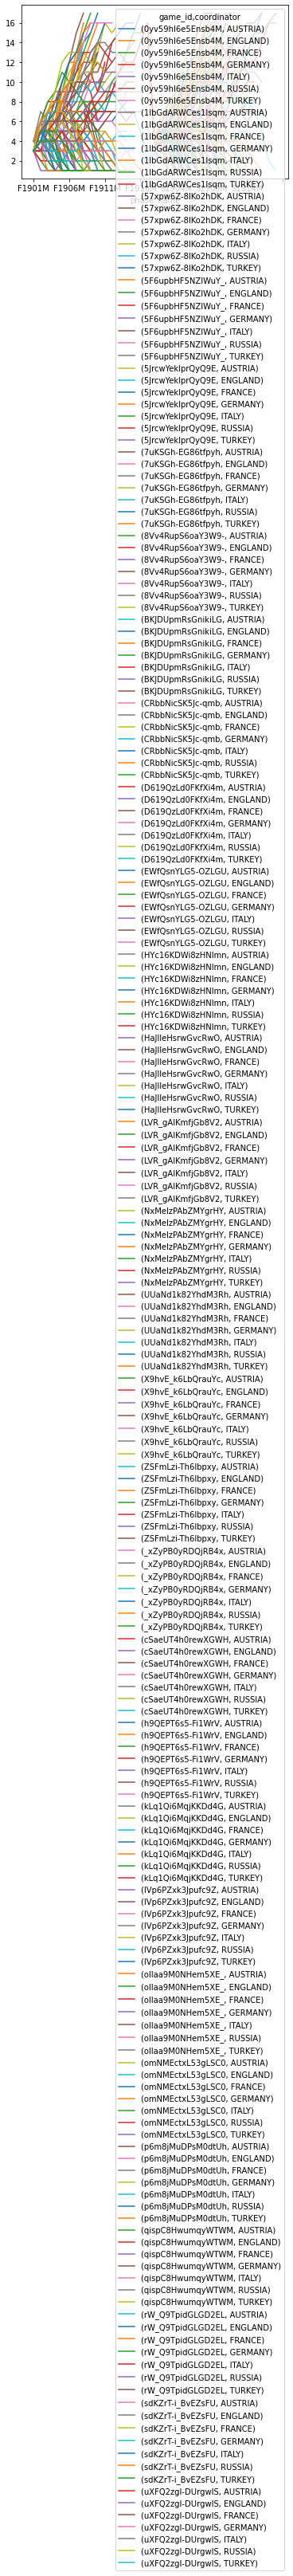

In [26]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['phase_name'].apply(lambda x:x[-1]) == 'M')
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().T.plot()

In [27]:
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().head(14)
cdf.groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

phase_id                       0    1    2    3    4    5    6    7    8   \
game_id          coordinator                                                
0yv59hl6e5Ensb4M AUSTRIA      3.0  3.0  1.0  4.0  NaN  4.0  NaN  NaN  4.0   
                 ENGLAND      3.0  3.0  2.0  5.0  1.0  5.0  1.0  NaN  5.0   
                 FRANCE       3.0  3.0  2.0  5.0  NaN  5.0  NaN  NaN  5.0   
                 GERMANY      3.0  3.0  2.0  5.0  NaN  5.0  NaN  NaN  5.0   
                 ITALY        3.0  3.0  2.0  5.0  1.0  5.0  NaN  NaN  5.0   
                 RA           NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
                 RUSSIA       4.0  4.0  2.0  6.0  NaN  6.0  NaN  NaN  5.0   
                 TURKEY       3.0  3.0  1.0  4.0  NaN  4.0  NaN  1.0  5.0   

phase_id                       9   ...  66  67  68  69  70  71  72  73  74  75  
game_id          coordinator       ...                                          
0yv59hl6e5Ensb4M AUSTRIA      NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 ENGLAND      NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 FRANCE       NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 GERMANY      NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 ITALY        NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 RA           NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 RUSSIA       2.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                 TURKEY       NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[8 rows x 76 columns]

In [28]:
cnd=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['game_id'].apply(lambda x: x == '0yv59hl6e5Ensb4M') )
cdf[cnd].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(7)

phase_id                       0    1    3    5    8    10   13   15   18  \
game_id          coordinator                                                
0yv59hl6e5Ensb4M AUSTRIA      3.0  3.0  4.0  4.0  4.0  4.0  4.0  3.0  3.0   
                 ENGLAND      3.0  3.0  5.0  5.0  5.0  5.0  4.0  4.0  1.0   
                 FRANCE       3.0  3.0  5.0  5.0  5.0  5.0  7.0  7.0  9.0   
                 GERMANY      3.0  3.0  5.0  5.0  5.0  5.0  4.0  3.0  4.0   
                 ITALY        3.0  3.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   
                 RUSSIA       4.0  4.0  6.0  6.0  5.0  5.0  4.0  4.0  5.0   
                 TURKEY       3.0  3.0  4.0  4.0  5.0  5.0  6.0  6.0  7.0   

phase_id                       20    23    25    28    30    33    35    38  \
game_id          coordinator                                                  
0yv59hl6e5Ensb4M AUSTRIA      2.0   2.0   2.0   2.0   2.0   2.0   2.0   NaN   
                 ENGLAND      1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                 FRANCE       9.0  10.0  10.0  12.0  12.0  15.0  15.0  17.0   
                 GERMANY      4.0   4.0   3.0   2.0   1.0   NaN   NaN   NaN   
                 ITALY        5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   
                 RUSSIA       5.0   5.0   5.0   5.0   5.0   4.0   3.0   3.0   
                 TURKEY       7.0   8.0   8.0   8.0   8.0   8.0   8.0  10.0   

phase_id                        40  
game_id          coordinator        
0yv59hl6e5Ensb4M AUSTRIA       NaN  
                 ENGLAND       NaN  
                 FRANCE       17.0  
                 GERMANY       NaN  
                 ITALY         4.0  
                 RUSSIA        2.0  
                 TURKEY       10.0

In [29]:
cdf[spring_fall_phases].loc[cdf["game_id"] == "0yv59hl6e5Ensb4M"]

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
8892,0yv59hl6e5Ensb4M,0,S1901M,AUSTRIA,A,VIE,-,[],GAL,1
8893,0yv59hl6e5Ensb4M,0,S1901M,AUSTRIA,F,TRI,-,[],ALB,2
8894,0yv59hl6e5Ensb4M,0,S1901M,AUSTRIA,A,BUD,-,[],SER,3
8895,0yv59hl6e5Ensb4M,0,S1901M,ENGLAND,F,EDI,-,[],NWG,4
8896,0yv59hl6e5Ensb4M,0,S1901M,ENGLAND,A,LVP,-,[],YOR,5
...,...,...,...,...,...,...,...,...,...,...
9542,0yv59hl6e5Ensb4M,40,F1909M,TURKEY,F,ADR,S,[],[],52
9543,0yv59hl6e5Ensb4M,40,F1909M,TURKEY,A,VIE,S,[],[],72
9544,0yv59hl6e5Ensb4M,40,F1909M,TURKEY,A,TRI,S,[cut],[],74
9545,0yv59hl6e5Ensb4M,40,F1909M,TURKEY,A,BUD,-,[],SER,66


## Save a single game to JSON 

In [30]:
from pprint import pprint
import json

In [31]:
game_id = "uXFQ2zgI-DUrgwlS"
for game in games_jsons:
    if game['id'] == game_id:
        json.dump(game, open(f'{game_id}.json', 'w'))

# Calculate different triples

### Manual exploration

In [32]:
# for a single game:
game_id = "lVp6PZxk3Jpufc9Z"
game_df = cdf.loc[cdf["game_id"] == game_id]

In [33]:
game_df

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
855,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,A,VIE,H,[],[],1
856,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,F,TRI,H,[],[],2
857,lVp6PZxk3Jpufc9Z,0,S1901M,AUSTRIA,A,BUD,H,[],[],3
858,lVp6PZxk3Jpufc9Z,0,S1901M,ENGLAND,F,EDI,-,[],NTH,4
859,lVp6PZxk3Jpufc9Z,0,S1901M,ENGLAND,A,LVP,-,[],YOR,5
...,...,...,...,...,...,...,...,...,...,...
1443,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,A,WAR,-2,[],-2,48
1444,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,F,LYO,-2,[],-2,47
1445,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,F,TUN,-2,[],-2,15
1446,lVp6PZxk3Jpufc9Z,37,S1909M,ITALY,A,ROM,-2,[],-2,64


In [34]:
game_df["unique_unit_id"].nunique()

66

In [35]:
game_df["unique_unit_id"].max()

66

In [36]:
game_df.loc[game_df["unique_unit_id"].idxmax()]

game_id             lVp6PZxk3Jpufc9Z
phase_id                          37
phase_name                    S1909M
coordinator                    ITALY
type                               F
current_location                 ANK
action                            -2
results                           []
impact_location                   -2
unique_unit_id                    66
Name: 1441, dtype: object

In [37]:
players = game_df["coordinator"].unique()
assert len(players) == 7

In [38]:
player_units = {}
for player in players:
    player_units[player] = game_df.loc[game_df["coordinator"] == player]["unique_unit_id"].unique()

In [39]:
#https://stackoverflow.com/questions/45655936/how-to-test-all-items-of-a-list-are-disjoint
# make sure some units are handed over to other players

import itertools
def all_disjoint(iterables):
    merged = itertools.chain(*iterables)
    total = list(merged)
    total.sort()
    print(total)
    print(set(total))
    return len(total) == len(set(total))

In [40]:
all_units = list(player_units.values())

In [41]:
all_disjoint(all_units)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 13, 14, 14, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 25, 26, 27, 27, 28, 29, 30, 31, 32, 33, 33, 34, 35, 36, 36, 37, 38, 39, 40, 41, 41, 42, 43, 43, 43, 44, 45, 45, 46, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 58, 59, 60, 61, 62, 63, 64, 65, 66]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66}


False

In [60]:
player_units

{'AUSTRIA': array([ 1,  2,  3, 13, 14, 42, 25]),
 'ENGLAND': array([ 4,  5,  6, 23, 27, 28, 37, 38, 43, 44, 49, 50, 54, 55, 56, 57, 59,
        60]),
 'FRANCE': array([ 7,  8,  9, 29, 39, 23, 43]),
 'GERMANY': array([10, 11, 12, 24, 30, 27, 33]),
 'ITALY': array([13, 14, 15, 25, 26, 31, 32, 36, 40, 41, 45, 46, 47, 48, 51, 52, 53,
        43, 58, 61, 62, 63, 64, 65, 66]),
 'RUSSIA': array([16, 17, 18, 19, 33, 34, 35, 14, 13, 45, 36, 41, 58]),
 'TURKEY': array([20, 21, 22, 46])}

In [43]:
unique_two_players = set(itertools.permutations(player_units.keys(), 2))

In [42]:
len(unique_two_players)

42

In [239]:
from collections import namedtuple
Triple = namedtuple('Triple', ['triple', 'player_i', 'player_j'])

In [249]:
triples = []
for player_i, player_j in unique_two_players:
    if player_i== "TURKEY" and player_j == "AUSTRIA":
        print(player_i, player_j)
        p_units = list(itertools.combinations(player_units[player_i], 2))
        o_unit = list(itertools.combinations(player_units[player_j], 1))
        # get all 3-tuples unique combinations
        p_o_product = list(itertools.product(p_units, o_unit))
        p_o_product = [(a, b, c) for (a,b), (c,) in p_o_product]
        triple = [Triple(t, player_i, player_j) for t in p_o_product]
        triples.append(triple)
        # first tuple in the product belongs to player_i and the other belongs to player_j
        break

TURKEY AUSTRIA


In [255]:
len(triples)

1

In [236]:
Triple(p_1_name='TURKEY', p1_val=(1,2), p2_name='AUSTRIA', p2_val=3)

Triple(p_1_name='TURKEY', p1_val=(1, 2), p2_name='AUSTRIA', p2_val=3)

In [216]:
p_units = list(itertools.combinations(player_units["TURKEY"], 2))
o_unit = list(itertools.combinations(player_units["AUSTRIA"], 1))

In [228]:
p_units

[(20, 21), (20, 22), (20, 46), (21, 22), (21, 46), (22, 46)]

In [229]:
result = itertools.product(p_units, ["TURKEY"])

In [230]:
list(result)

[((20, 21), 'TURKEY'),
 ((20, 22), 'TURKEY'),
 ((20, 46), 'TURKEY'),
 ((21, 22), 'TURKEY'),
 ((21, 46), 'TURKEY'),
 ((22, 46), 'TURKEY')]

In [214]:
for i, _tuple in enumerate(all_tuples):
    all_tuples[i] = _tuple[0] + _tuple[1]

In [215]:
len(all_tuples)

42

In [208]:
all_tuples

[(22, 46, 2),
 (22, 46, 14),
 (22, 46, 1),
 (22, 46, 42),
 (22, 46, 25),
 (22, 46, 13),
 (22, 46, 3),
 (20, 46, 2),
 (20, 46, 14),
 (20, 46, 1),
 (20, 46, 42),
 (20, 46, 25),
 (20, 46, 13),
 (20, 46, 3),
 (21, 22, 2),
 (21, 22, 14),
 (21, 22, 1),
 (21, 22, 42),
 (21, 22, 25),
 (21, 22, 13),
 (21, 22, 3),
 (20, 22, 2),
 (20, 22, 14),
 (20, 22, 1),
 (20, 22, 42),
 (20, 22, 25),
 (20, 22, 13),
 (20, 22, 3),
 (21, 46, 2),
 (21, 46, 14),
 (21, 46, 1),
 (21, 46, 42),
 (21, 46, 25),
 (21, 46, 13),
 (21, 46, 3),
 (20, 21, 2),
 (20, 21, 14),
 (20, 21, 1),
 (20, 21, 42),
 (20, 21, 25),
 (20, 21, 13),
 (20, 21, 3)]

In [164]:
# p_units = set(itertools.combinations([1,2,3], 2))
# o_unit = set(itertools.combinations([4,5], 1))

# # get all 3-tuples unique combinations
# all_tuples = list(itertools.product(p_units, o_unit))

In [165]:
#https://www.geeksforgeeks.org/python-remove-duplicate-tuples-from-list-of-tuples/
def removeDuplicates(lst):
    return list(set([i for i in lst]))

In [166]:
all_unique_tuples = removeDuplicates(all_tuples)

In [167]:
len(all_unique_tuples)

42

In [168]:
for triple in all_unique_tuples:
    print(triple)
    condition = game_df["unique_unit_id"].apply(lambda x: x in triple)
    presence = game_df[condition]
    break

(22, 46, 25)


In [169]:
presence.sort_values(['unique_unit_id'])

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
876,lVp6PZxk3Jpufc9Z,0,S1901M,TURKEY,A,CON,H,[],[],22
1229,lVp6PZxk3Jpufc9Z,24,S1906R,TURKEY,A,SMY,D,[disband],[],22
1225,lVp6PZxk3Jpufc9Z,23,S1906M,TURKEY,A,SMY,-,"[bounce, dislodged]",ANK,22
1187,lVp6PZxk3Jpufc9Z,20,F1905M,TURKEY,A,SMY,-,[bounce],ANK,22
1155,lVp6PZxk3Jpufc9Z,18,S1905M,TURKEY,A,SMY,-,[bounce],CON,22
1108,lVp6PZxk3Jpufc9Z,15,F1904M,TURKEY,A,CON,H,[dislodged],[],22
1073,lVp6PZxk3Jpufc9Z,13,S1904M,TURKEY,A,CON,H,[],[],22
1030,lVp6PZxk3Jpufc9Z,10,F1903M,TURKEY,A,CON,S,[],[],22
1113,lVp6PZxk3Jpufc9Z,16,F1904R,TURKEY,A,CON,R,[],SMY,22
928,lVp6PZxk3Jpufc9Z,4,S1902M,TURKEY,A,CON,H,[],[],22


In [170]:
presence[presence["unique_unit_id"] == 22]

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
876,lVp6PZxk3Jpufc9Z,0,S1901M,TURKEY,A,CON,H,[],[],22
898,lVp6PZxk3Jpufc9Z,1,F1901M,TURKEY,A,CON,H,[],[],22
928,lVp6PZxk3Jpufc9Z,4,S1902M,TURKEY,A,CON,H,[],[],22
953,lVp6PZxk3Jpufc9Z,6,F1902M,TURKEY,A,CON,H,[],[],22
995,lVp6PZxk3Jpufc9Z,8,S1903M,TURKEY,A,CON,H,[],[],22
1030,lVp6PZxk3Jpufc9Z,10,F1903M,TURKEY,A,CON,S,[],[],22
1073,lVp6PZxk3Jpufc9Z,13,S1904M,TURKEY,A,CON,H,[],[],22
1108,lVp6PZxk3Jpufc9Z,15,F1904M,TURKEY,A,CON,H,[dislodged],[],22
1113,lVp6PZxk3Jpufc9Z,16,F1904R,TURKEY,A,CON,R,[],SMY,22
1155,lVp6PZxk3Jpufc9Z,18,S1905M,TURKEY,A,SMY,-,[bounce],CON,22


In [171]:
presence[presence["unique_unit_id"] == 22]["phase_name"].value_counts()

S1901M    1
F1901M    1
S1902M    1
F1902M    1
S1903M    1
F1903M    1
S1904M    1
F1904M    1
F1904R    1
S1905M    1
F1905M    1
S1906M    1
S1906R    1
Name: phase_name, dtype: int64

In [172]:
phases = presence["phase_name"].value_counts() == 2

In [173]:
phases.to_dict()

{'S1905M': True,
 'S1902M': True,
 'F1902M': True,
 'S1903M': True,
 'F1903M': True,
 'S1904M': True,
 'F1904M': True,
 'F1904R': True,
 'W1904A': True,
 'F1905M': True,
 'S1906M': True,
 'S1907M': False,
 'F1908R': False,
 'F1908M': False,
 'S1908M': False,
 'F1907M': False,
 'S1901M': False,
 'F1906M': False,
 'S1906R': False,
 'F1901M': False,
 'W1901A': False,
 'W1908A': False}

In [188]:
eligible_phases = presence.loc[presence["phase_name"].apply(lambda x: x in phases and phases[x])]

In [189]:
eligible_phases

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
919,lVp6PZxk3Jpufc9Z,4,S1902M,ITALY,A,VEN,-,[],TYR,25
928,lVp6PZxk3Jpufc9Z,4,S1902M,TURKEY,A,CON,H,[],[],22
944,lVp6PZxk3Jpufc9Z,6,F1902M,ITALY,A,TYR,-,[bounce],TRI,25
953,lVp6PZxk3Jpufc9Z,6,F1902M,TURKEY,A,CON,H,[],[],22
981,lVp6PZxk3Jpufc9Z,8,S1903M,ITALY,A,TYR,-,[],TRI,25
995,lVp6PZxk3Jpufc9Z,8,S1903M,TURKEY,A,CON,H,[],[],22
1015,lVp6PZxk3Jpufc9Z,10,F1903M,ITALY,A,TRI,-,[],SER,25
1030,lVp6PZxk3Jpufc9Z,10,F1903M,TURKEY,A,CON,S,[],[],22
1065,lVp6PZxk3Jpufc9Z,13,S1904M,ITALY,A,SER,S,[],[],25
1073,lVp6PZxk3Jpufc9Z,13,S1904M,TURKEY,A,CON,H,[],[],22


In [191]:
old_ids = eligible_phases["phase_id"].unique()

In [202]:
old_ids = old_ids.tolist()

In [203]:
new_ids = np.arange(1, len(old_ids)+1)

In [205]:
eligible_phases

,game_id,phase_id,phase_name,coordinator,type,current_location,action,results,impact_location,unique_unit_id
919,lVp6PZxk3Jpufc9Z,4,S1902M,ITALY,A,VEN,-,[],TYR,25
928,lVp6PZxk3Jpufc9Z,4,S1902M,TURKEY,A,CON,H,[],[],22
944,lVp6PZxk3Jpufc9Z,6,F1902M,ITALY,A,TYR,-,[bounce],TRI,25
953,lVp6PZxk3Jpufc9Z,6,F1902M,TURKEY,A,CON,H,[],[],22
981,lVp6PZxk3Jpufc9Z,8,S1903M,ITALY,A,TYR,-,[],TRI,25
995,lVp6PZxk3Jpufc9Z,8,S1903M,TURKEY,A,CON,H,[],[],22
1015,lVp6PZxk3Jpufc9Z,10,F1903M,ITALY,A,TRI,-,[],SER,25
1030,lVp6PZxk3Jpufc9Z,10,F1903M,TURKEY,A,CON,S,[],[],22
1065,lVp6PZxk3Jpufc9Z,13,S1904M,ITALY,A,SER,S,[],[],25
1073,lVp6PZxk3Jpufc9Z,13,S1904M,TURKEY,A,CON,H,[],[],22


In [184]:
phase_ids = presence.loc[presence["phase_name"].apply(lambda x: x in phases and phases[x])].phase_id.unique()

In [211]:
phase_ids.max()

23

In [186]:
phase_ids.min()

4

In [187]:
triple

(22, 46, 25)

### Sanity check that the code works

In [85]:
for game_id in unique_games:
    game_df = cdf.loc[cdf["game_id"] == game_id]
    assert game_df["unique_unit_id"].nunique() == game_df["unique_unit_id"].max(), game_id

In [ ]:
triples = []
for game_id in unique_games:
    game_df = cdf.loc[cdf["game_id"] == game_id]

# Loading Deepmind's Diplomacy trajectory

In [ ]:
action_outputs = np.load(file='../data/actions_outputs.npz', allow_pickle=True)

In [ ]:
action_outputs[1][0]

In [ ]:
pd.DataFrame.from_dict(action_outputs[0][0]).corr(method='pearson')

In [ ]:
legal_actions = np.load(file='../data/legal_actions.npz', allow_pickle=True)

In [ ]:
len(legal_actions)

In [ ]:
legal_actions[0].shape

In [ ]:
observations = np.load(file='../data/observations.npz', allow_pickle=True)

In [ ]:
len(observations)

In [ ]:
observations[1]

In [ ]:
step_outputs = np.load(file='../data/step_outputs.npz', allow_pickle=True)

In [ ]:
len(step_outputs)

In [ ]:
step_outputs[0]